In [117]:
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import pandas as pd
from sklearn.preprocessing import LabelEncoder as le

In [118]:
df_raw = pd.read_excel("output/resampled_df_10_min.xlsx", index_col=[0])

In [119]:
start_date = pd.to_datetime(f"2023-06-17 00:00:00")
end_date = pd.to_datetime(f"2023-08-07 23:50:00")
model_features = ["hour", "weekday", "window_block"] # Day = day of the month (0-31), hour = hour of the day (0-24), weekday = day in the week (0-7), window_block = window block in the hour (0-5)

In [120]:
df = df_raw[df_raw["time"].between(start_date, end_date)].copy()

label_encoder = le()
df.location = label_encoder.fit_transform(df.location)

In [121]:
df.head()

,time,location
144,2023-06-17 00:00:00,2
145,2023-06-17 00:10:00,2
146,2023-06-17 00:20:00,2
147,2023-06-17 00:30:00,2
148,2023-06-17 00:40:00,2


In [122]:
df["weekday"] = df["time"].dt.dayofweek
df["hour"] = df["time"].dt.hour
df["day"] = df["time"].dt.day
df["window_block"] = ((df['time'].dt.minute * 60 + df['time'].dt.second) // 600).astype(int)


In [123]:
df

,time,location,weekday,hour,day,window_block
144,2023-06-17 00:00:00,2,5,0,17,0
145,2023-06-17 00:10:00,2,5,0,17,1
146,2023-06-17 00:20:00,2,5,0,17,2
147,2023-06-17 00:30:00,2,5,0,17,3
148,2023-06-17 00:40:00,2,5,0,17,4
...,...,...,...,...,...,...
7627,2023-08-07 23:10:00,3,0,23,7,1
7628,2023-08-07 23:20:00,3,0,23,7,2
7629,2023-08-07 23:30:00,3,0,23,7,3
7630,2023-08-07 23:40:00,3,0,23,7,4


In [124]:
df

,time,location,weekday,hour,day,window_block
144,2023-06-17 00:00:00,2,5,0,17,0
145,2023-06-17 00:10:00,2,5,0,17,1
146,2023-06-17 00:20:00,2,5,0,17,2
147,2023-06-17 00:30:00,2,5,0,17,3
148,2023-06-17 00:40:00,2,5,0,17,4
...,...,...,...,...,...,...
7627,2023-08-07 23:10:00,3,0,23,7,1
7628,2023-08-07 23:20:00,3,0,23,7,2
7629,2023-08-07 23:30:00,3,0,23,7,3
7630,2023-08-07 23:40:00,3,0,23,7,4


In [125]:
train_start_date = start_date
train_end_date = train_start_date + pd.Timedelta(days=7, hours=23, minutes=50)
test_start_date = train_end_date + pd.Timedelta(minutes=10)
test_end_date = test_start_date + pd.Timedelta(days=6, hours=23, minutes=50)

train_mask = df["time"].between(train_start_date, train_end_date)
test_mask = df["time"].between(test_start_date, test_end_date)

# Split the data into train and test sets
X_train = df.loc[train_mask, model_features]
y_train = df.loc[train_mask, "location"]
X_test = df.loc[test_mask, model_features]
y_test = df.loc[test_mask, "location"]

print(f"Training: {train_start_date}-{train_end_date}, testing: {test_start_date}-{test_end_date}.")

Training: 2023-06-17 00:00:00-2023-06-23 23:50:00, testing: 2023-06-24 00:00:00-2023-06-30 23:50:00.


In [126]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions for 14 days into the future. 
predictions = model.predict(X_test) # Or use predict_proba

In [127]:
print(accuracy_score(y_test, predictions))

0.5595238095238095


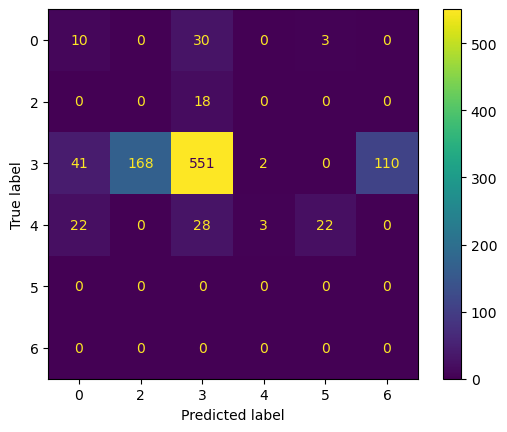

In [128]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [129]:
df.location = label_encoder.inverse_transform(df.location)

Message (heatmap visualizer): Making heatmap with 1008 records, starting at 2023-06-17T00:00:00.000000000 and ending at 2023-06-23T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_training.png.
Message (heatmap visualizer): Making heatmap with 1008 records, starting at 2023-06-24T00:00:00.000000000 and ending at 2023-06-30T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_predicted.png.
Message (heatmap visualizer): Making heatmap with 1008 records, starting at 2023-06-24T00:00:00.000000000 and ending at 2023-06-30T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_actual.png.


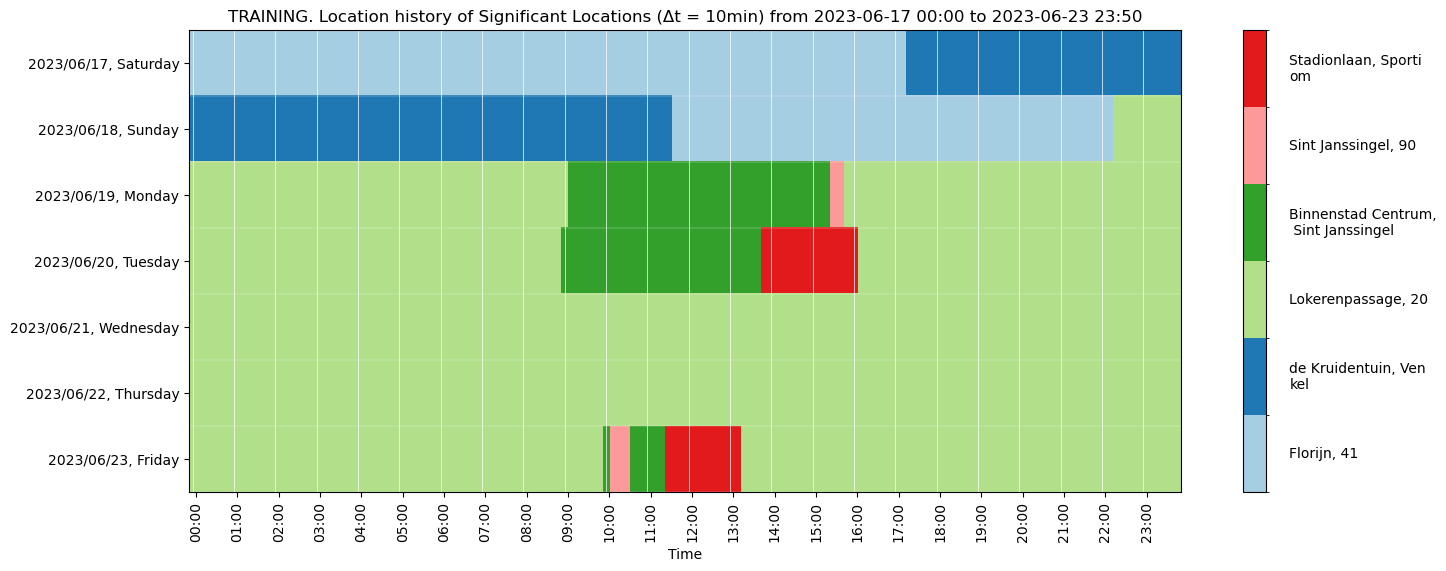

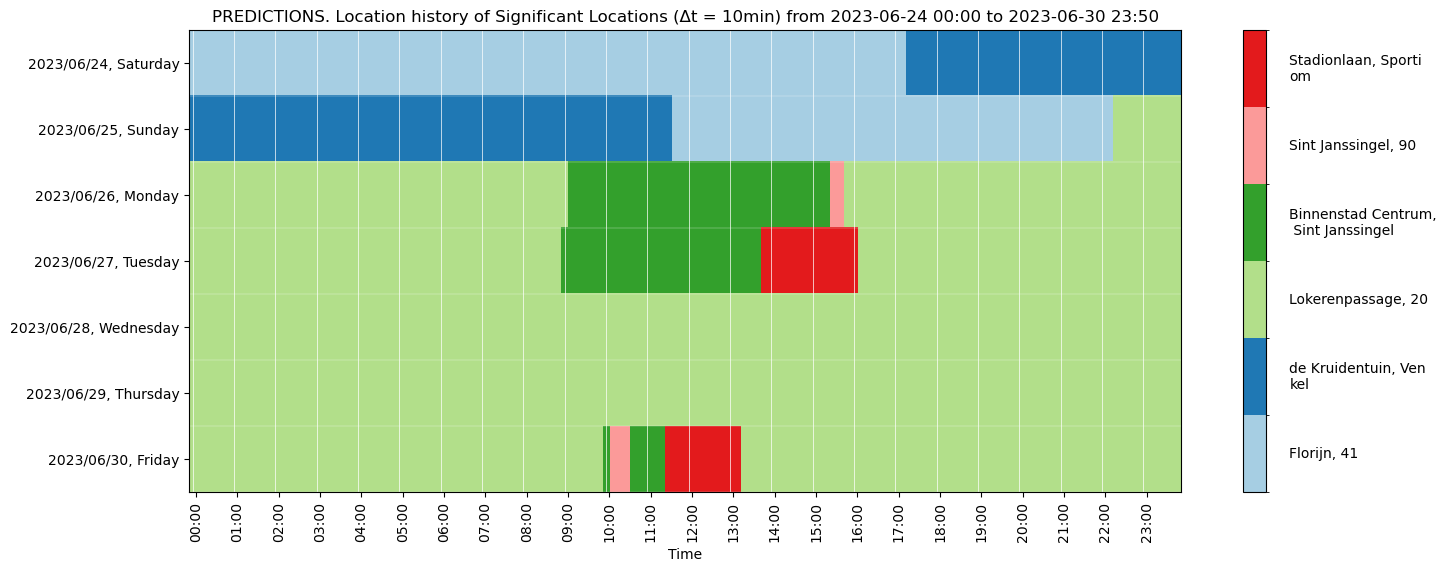

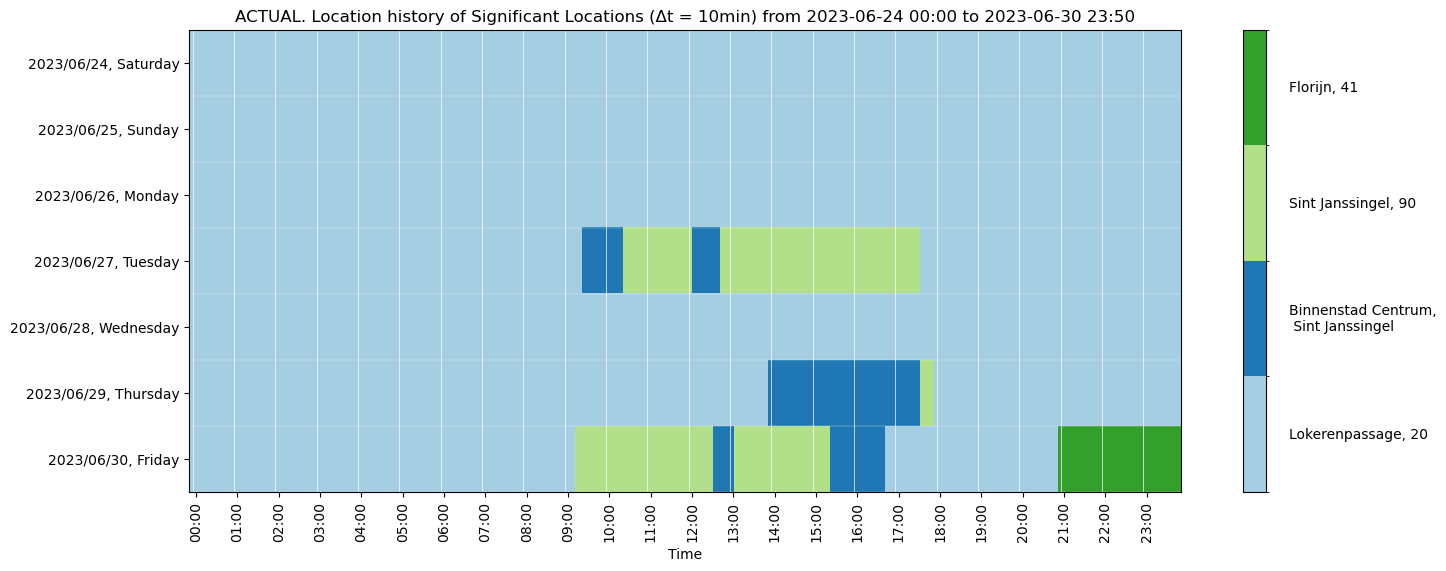

In [130]:
from Visualisations import HeatmapVisualizer


time_intervals = pd.date_range(
    start=test_start_date, end=test_end_date, freq="10T"
)

# Create a DataFrame with the 'time' column and the 'location' column that holds the predicted locations (strings).
df_predictions = pd.DataFrame(
    {
        "time": time_intervals,
        "location": label_encoder.inverse_transform(predictions),
    }
)

HeatmapVisualizer(
    str(train_start_date.date()),
    str(train_end_date.date()),
    df.loc[train_mask][["location", "time"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    name="heatmap_training",
    title="TRAINING",
)

HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df_predictions,
    name="heatmap_predicted",
    title="PREDICTIONS",
)

HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df.loc[test_mask][["location", "time"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    name="heatmap_actual",
    title="ACTUAL",
)